# ` GPN Intelligence Cup 2020: Data Science`

# &1. Анализ исходных данных 

In [1]:
import pandas as pd
import numpy as np

## 1.1. Анализ данных по продажам

In [2]:
sales = pd.read_parquet('sales.parquet')
sales.head(5) # посмотрим на общий вид данных, в каждом из магазинов может продаваться несколько типов продукции

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


In [3]:
sales.info() # размер df, типы данных df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081459 entries, 0 to 5081458
Data columns (total 6 columns):
date                  datetime64[ns]
shop_id               int64
owner                 object
number_of_counters    int32
goods_type            object
total_items_sold      float64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 213.2+ MB


In [4]:
sales.isna().values.any() # отлично, пропусков в данных по продажам нет

False

In [5]:
sales['owner'].value_counts() # все возможные владельцы магазинов, 5 видов

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [6]:
sales['goods_type'].value_counts() # все возможные типы товаров

Бензак                615722
Солярка               585314
Съедобный хлам        551292
Хлам                  540485
Патроны               505188
Броня и одежда        493856
Ядер-Кола             474912
Медпрепараты и еда    413378
Модификации тачки     353090
Жидкости для тачки    320589
Оружие                227633
Name: goods_type, dtype: int64

In [7]:
sales['total_items_sold'].value_counts()[-1] # total_items_sold содержит отрицательные значения!

10

In [8]:
len(set(sales['shop_id'])) # количество уникальных id магазинов

845

## 1.2. Анализ данных по характеристикам магазинов

In [9]:
shops = pd.read_parquet('shops.parquet') 
shops.head(5) # замечен первый None

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [10]:
shops.info() # размер df и типы данных
# количество строк в shops совпадает с количеством уникальных id, значит информация по характеристикам магазинов уникальна, данные есть по каждому магазину 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 8 columns):
shop_id                        845 non-null int32
neighborhood                   845 non-null object
city                           788 non-null object
year_opened                    845 non-null int32
is_on_the_road                 838 non-null object
is_with_the_well               785 non-null object
is_with_additional_services    784 non-null object
shop_type                      713 non-null object
dtypes: int32(2), object(6)
memory usage: 46.3+ KB


In [11]:
shops.isna().values.any() # подтверждение присутствия пропусков в данных 

True

In [12]:
for i in shops.columns:
    print(i, shops[i].isna().values.any()) # пропуски в колонках city, is_on_the_road, is_with_the_well, is_with_additional_services, shop_type 

shop_id False
neighborhood False
city True
year_opened False
is_on_the_road True
is_with_the_well True
is_with_additional_services True
shop_type True


In [13]:
shops['year_opened'].value_counts()[:2] # в значениях года присутствуют отрицательные значения (год открытия неизвестен)!

 2139    94
-1       63
Name: year_opened, dtype: int64

In [14]:
shops['shop_type'].value_counts() # все возможные типы магазинов

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [15]:
shops['neighborhood'].value_counts() # все возможные значения neighborhood

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

## 1.3. Анализ данных о разбивке городов по локациям

In [19]:
cities = pd.read_parquet('cities.parquet')
cities.head(5)

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь


In [20]:
cities.info() # размер df и тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
city        15 non-null object
location    15 non-null object
dtypes: object(2)
memory usage: 368.0+ bytes


# &2. Отбор информативных признаков

In [21]:
from sklearn import preprocessing

## 2.1 Формирование признаков по типам продаваемой продукции

* Из таблицы sales видно, что в каждом из магазинов может продаваться несколько видов товара. Возможно, разные магазины специализируются на разных видах товаров, поэтому вклад признака __"вид товара"__, несомненно,  __будет влиять на результат итоговой кластеризации магазинов__
* Разбиение кластеров по типам продукции интуитивно логично. Например, в магазинах, специализирующихся на "Съедобном хламе", можно проводить одни промокампании и выстраивать определенные макркетинговые стратегии, а в магазинах, специализирующихся на "Солярке", будут использоваться совершеннно другие стратегии

In [24]:
# группирую данные, так, что каждому id соответствует уникальный тип товара и сумма всех проданных товаров данного типа товара
shop_info = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})
shop_info.head(10) # полученная группировка

,shop_id,goods_type,total_items_sold
0,0,Бензак,11647666.0
1,0,Броня и одежда,81.0
2,0,Жидкости для тачки,35.0
3,0,Съедобный хлам,1077.0
4,0,Хлам,1351.0
5,1,Бензак,9079168.0
6,1,Броня и одежда,1236.0
7,1,Жидкости для тачки,298.0
8,1,Солярка,1548661.0
9,1,Съедобный хлам,20340.0


In [25]:
goods = set(shop_info['goods_type']) # получаю множество уникалных типов товаров
ids = set(shop_info['shop_id']) # получаю множество уникальных shop id  
X = pd.DataFrame({"shop_id":pd.Series(list(ids))}) # создаю колонку со списком shop_id, чтобы потом добавлять к ней сформированные признаки признаки

In [26]:
# поочередно создаю колонки вида shop_id - количество проданного товара определенного типа и добавляю их к X
for type_i in goods:
    feature = sales[sales['goods_type'] == type_i].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})
    feature = feature.rename(columns={'total_items_sold': type_i})
    X = pd.merge(left=X, right=feature, left_on='shop_id', right_on='shop_id',  how='outer')

In [27]:
# таким образом, X содержит информацию о количестве проданного товара определенного типа по каждому shop_id
X.head(10) 

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,Модификации тачки
0,0,1077.0,NaN,NaN,NaN,81.0,35.0,1351.0,NaN,NaN,11647666.0,NaN
1,1,20340.0,1548661.0,NaN,NaN,1236.0,298.0,5321.0,NaN,NaN,9079168.0,NaN
2,2,115414.0,1378414.0,2526.0,47141.0,21571.0,3550.0,39997.0,636472.0,3109.0,7953184.0,5527.0
3,3,32051.0,2399400.0,30.0,5.0,754.0,13286.0,17724.0,NaN,NaN,23048831.0,61.0
4,4,289664.0,3258548.0,844.0,161995.0,13826.0,15438.0,79956.0,797282.0,37541.0,23389524.0,16925.0
5,5,284567.0,2451011.0,8778.0,237754.0,38255.0,12466.0,86394.0,860789.0,48769.0,21835937.0,17291.0
6,6,70612.0,3223573.0,NaN,12318.0,1378.0,4980.0,18157.0,NaN,NaN,11627584.0,211.0
7,7,44845.0,921224.0,476.0,29458.0,3843.0,2539.0,39762.0,102628.0,111.0,11104626.0,1675.0
8,8,237388.0,997187.0,535.0,165528.0,4444.0,12815.0,62788.0,215113.0,10689.0,4228536.0,6542.0
9,9,80611.0,5883914.0,77.0,44894.0,468.0,12806.0,59839.0,NaN,NaN,9175262.0,543.0


### Требуется обработка полученных данных:
* данные содержат nan 
* необходима нормализация признаков: значения ячеек слишком большие, удобнее рассматривать долю каждого из типов товаров в сумме общих продаж магазина, а не количество проданного товара

In [29]:
X = X.fillna(0)# заполняем nan нулями
df = X.drop(columns=['shop_id']) # убираем shop_id, нормализация данного признака не требуется 
normalized_X =pd.DataFrame(preprocessing.normalize(df), columns = df.columns) # нормализация
data1 = pd.concat([X["shop_id"], normalized_X], axis=1)
data1.head(10)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,Модификации тачки
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,1.000000,0.000000
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.985760,0.000000
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.982130,0.000683
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.994624,0.000003
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.989765,0.000716
5,5,0.012939,0.111443,0.000399,1.081028e-02,0.001739,0.000567,0.003928,0.039139,0.002217,0.992844,0.000786
6,6,0.005852,0.267153,0.000000,1.020853e-03,0.000114,0.000413,0.001505,0.000000,0.000000,0.963634,0.000017
7,7,0.004024,0.082670,0.000043,2.643527e-03,0.000345,0.000228,0.003568,0.009210,0.000010,0.996516,0.000150
8,8,0.054447,0.228715,0.000123,3.796553e-02,0.001019,0.002939,0.014401,0.049338,0.002452,0.969858,0.001500
9,9,0.007395,0.539790,0.000007,4.118575e-03,0.000043,0.001175,0.005490,0.000000,0.000000,0.841738,0.000050


## 2.2 Формирование признаков по характеристикам магазинов 

* Добавим ещё некоторые наборы признаков из данных по характеристикам магазинов. Такие признаки как neighborhood, is_on_the_road, is_with_additional_services, shop_type - носят ограмный информативный характер
* __Почему эти признаки важны?__ В реальной жизни в магазин у дома люди чаще заходят за продуктами для приготовления ужина, в магазин около бизнес-центра зайдут скорее за обедом или фруктами. Возможно, и в нашем случае в магазине "В центе" и в магазине "На отшибе" спрос на товары может сильно отличаться, поэтому признаки __neighborhood, is_on_the_road, shop_type__  могут потенциально внести огромный вклад в итоговою кластеризацию
* __is_with_additional_services__ - весомый бинарный признак. Представим ситуацию: у нас есть два типа АЗС. В АЗС первого типа на территории есть минимаркет, в АЗС другого типа соответственно минимаркета нет. Понятно, что прогнозировать спрос для этих двух типов АЗС нужно по-разному, более того, в данном случае будут использоваться разные стратегии управления и маркетинга, будут планироваться разные промокампании 


In [30]:
shops.head(5)# заметим, что shop_id не отсортированы 

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [31]:
shops = shops.sort_values('shop_id') # отсортируем shop_id, чтобы впоследствие было удобнее конкатенировать признаки
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
259,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
770,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
592,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
701,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
628,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


Как было замечено в пункте 1.2 строки is_on_the_road, is_with_the_well, is_with_additional_services, shop_type содержат nan, более того, эти строки имеют тип object

In [32]:
shops = shops.replace('да', 1) # преобразуем категориальные признаки в числовые
shops = shops.replace('нет', 0) # преобразуем категориальные признаки в числовые
shops[['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']] = shops[['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']].fillna(0)
shops['shop_type'] = shops['shop_type'].fillna('1') # заменяем None на медианное значение shop_type (т.к значения shop_type имеют тип object)

In [33]:
# преобразуем категориальный признак neighborhood с помощью dummy-кодирования в набор бинарных признаков
(pd.get_dummies(shops["neighborhood"])).head(5)

,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
259,1,0,0,0,0,0,0
770,1,0,0,0,0,0,0
592,0,0,1,0,0,0,0
701,0,0,0,0,0,1,0
628,1,0,0,0,0,0,0


In [34]:
# добавим полученные признаки к признакам из пункта 2.1
neigh_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["neighborhood"])], axis=1) 
data2 = pd.merge(left=data1, right=neigh_id, left_on='shop_id', right_on='shop_id',  how='outer')
data2.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,Модификации тачки,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,1.000000,0.000000,1,0,0,0,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.985760,0.000000,1,0,0,0,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.982130,0.000683,0,0,1,0,0,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.994624,0.000003,0,0,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.989765,0.000716,1,0,0,0,0,0,0


* Признак __shop_type__ в данном случае является категориальнм (числовые значения лишь кодируют тип), поэтому необходимо также использовать dummy-кодирование для обработки данного признака

In [35]:
type_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["shop_type"])], axis=1) 
data3 = pd.merge(left=data2, right=type_id, left_on='shop_id', right_on='shop_id',  how='outer')
# переименуем столбцы с типом для более удобной работы
for i in range(1, 5):
    data3 = data3.rename(columns={f'{i}': f'shop_type_{i}'})
data3.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,1,0,0,0,0,0,1,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,0,0,0,1,0,0,0


* добавим признаки is_on_the_road, is_with_the_well, is_with_additional_service к уже сформированным признакам

In [98]:
data4 = pd.merge(left=data3, right=shops[['shop_id','is_on_the_road', 'is_with_the_well', 'is_with_additional_services']], left_on='shop_id', right_on='shop_id',  how='outer')
data4.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,1,0,0,0,0.0,0.0,0.0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,1,0,0,0,0.0,0.0,0.0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,0,0,0,1,0,0,0.0,0.0,1.0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,1,0,0,0,1,0,0.0,0.0,0.0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,1,0,0,0,0.0,0.0,1.0


## 2.3 Формирование гипотетически информативных признаков

* Возможно, такие признаки как __year__ - год основания магазина и __city__ - локация магазина __способны улучшить итоговую кластеризацию__ 
* Вполне логично, что новые магазины привлекают больше посетителей, соответственно спрос в таких магазинах может быть выше. Но это лишь предположение, которое будет проверено на практике при построении кластеров
* Каждый регион имеет свои особенности и свою сезонность: например в Сибири и на Дальнем Востоке заморозки начинаются с первой половины осени, а значит спрос, например, на дизельное топливо упадет раньше, чем в Санкт-Петербурге и Ленинградской области. Данный признак также гипотетически может внести вклад в итоговую клвстеризацию
* Проверки требует и признак __owner__ из характеристик по продажам. Возможно, от владельца группы магазинов и от реализуемой стратегии зависит уровень продаж товаров в данных магазинах. Проверим, как полияет этот признак на итоговую клвстеризацию

Нормализуем значения признака "year" и добавим его к уже сформированным признакам: 

In [101]:
year = shops["year_opened"]
mean_value = round(shops[year!= -1]["year_opened"].mean())
year = year.replace(-1, mean_value) # заменяем -1 на медианное значение столбца year
year = (year-year.min())/(year.max()-year.min()) # нормализация данных
year_id = pd.concat([shops['shop_id'], year], axis=1) 
data4 = pd.merge(left=data3, right=year_id, left_on='shop_id', right_on='shop_id',  how='outer') # формируем набор с признаками
data4.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,year_opened
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0.898551
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0.594203
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,1,0,0,0,0,0,1,0,0,0.594203
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0.260870
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,0,0,1,0,0,0,0.492754


Заменим пропуски и обработаем признак city с помощью dummy-кодированния:

In [113]:
city_id = pd.concat([shops['shop_id'], pd.get_dummies(shops['city'])], axis=1) 
city_id = city_id.fillna(0)
data5 = pd.merge(left=data4, right=city_id, left_on='shop_id', right_on='shop_id',  how='outer')
data5.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,Лагерь,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,1,0,0,0,0,0,0,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,1,0,0,0,0,0,0,0,0


In [114]:
data5.isna().values.any() # убедиkbcm, что в признаках нет nan

False

In [ ]:
формирование признака owners

In [ ]:
shop_owners = sales.groupby(['shop_id','owner'],as_index=False).aggregate({'total_items_sold': 'sum'})
print(shop_owners.shape) # у некоторых shop id менялись owners 
shop_owners = shop_owners.drop_duplicates(subset ="shop_id") # удалим дубликаты shop id, чтобы учитывать только текущих владельцев
print(shop_owners.shape) # 845 - как раз столько, сколько имеется уникальных shop id
shop_owners.head()

owners_dummy = pd.get_dummies(owner_features["owner"])
id_owners = pd.concat([shop_owners['shop_id'], owners_dummy], axis=1)
data6 = pd.merge(left=data5, right=id_owners, left_on='shop_id', right_on='shop_id', how = 'outer')



## & 3. Выбор метрик качества кластеризации

In [38]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [40]:
hopkins(data4)

0.5776724609711585

среднее внутрикластерное расстояние, среднее межкластерное расстояние, комбинации функционалов и коэффициент силуэта

## & 4. Реализация алгоритмов кластеризации и проверка качества

### 4.1. DBSCAN

In [46]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score

In [42]:
# df2 = data2.drop(columns=['shop_id']).copy()
df3 = data3.drop(columns=['shop_id']).copy()
df4 = data4.drop(columns=['shop_id']).copy()
# df4 = data4.drop(columns=['shop_id']).copy()
# df5 = data5.drop(columns=['shop_id']).copy()
d = df3.to_numpy()


In [43]:
d1 = df4.to_numpy()

In [53]:
dbscan = DBSCAN(eps=1.4, min_samples=5)# как выбирать параметры?
 
dbscan.fit(d1)
 

algo_labels = dbscan.labels_
# Готово! Распечатаем метки принадлежности к кластерам
print(metrics.silhouette_score(d1, algo_labels))
print(dbscan.labels_)

0.5232734673170304
[ 0  0  1  2  0  3  0  0  0  4  5  0  0  6  7  7  8  9  9 10 11  8  7 12
  0  9  0 13  0  3  0  3  0  9  0  6  3  0 10 14  0 15  7  0  5  0 15 16
  8 13  8  0 13  6 12 17  0 -1 15  0  0  9  0  0  0  0  1  1 15  0 15  0
  1 18  6  1  0  1 10  9  8  0  0  1 15 12 13 10 19  0 13  0 14  6  9 13
 14  1  6 14  6  0  6  0 13 13  0 13  0  6 16  0 14  0  0  1  0  9 13  0
  0  0  0  9  0  0  0  3  0  0  0 19  0  0 19  9  0  0  9  0 12  0  0  0
  0  0 17 17 -1  0  0 10 16 19 13  0  0  0 17  0 -1  0  9  9  0 19  8 19
 10 19 19 19 14 19 13 19 19 16  9 17  2 17  4 19 19  0  5 13 19  3  0 19
  0 11 19 19  6 10  0 19  9  1 11 10 11 11 11  0  8  2  0 11 15 11  0  0
  2  0 20 11 17  0 10 10 20 20  3 13 20 10 14 14 10  0  0  0 15 12  2 10
 14 15 15 11 11 14 11 12  2 11 10  2 10  5 17  0 11 11 10 10 20 15 10 11
 10 11 10 10 13 14 13  0  2  0  0 11  0 -1  0  0  0  8  2 20  2  0  2 13
 10 17 17  0 17 17 15 13 16  0 10 13 13 13 10 20 20 10  0 10  0 10 10 16
  0 16 13 23 14 10 14 17 13 16  

In [ ]:
коэффициент помимо силуэта Calinski-Harabasz index 

In [1404]:
metrics.calinski_harabasz_score(x, y)
davies_bouldin_score(x, y)

1.2890282887482225

[0.01537802 0.00819249 0.00665508 0.01166593 0.01039901 0.01002309
 0.00886031 0.00991379 0.00704134 0.00683774 0.01088143 0.17252252
 0.08570892 0.04709882 0.02845507 0.06231265 0.06220591 0.11021219
 0.1201793  0.08326968 0.05802225 0.04490908 0.01035795 0.00139674
 0.00750069]


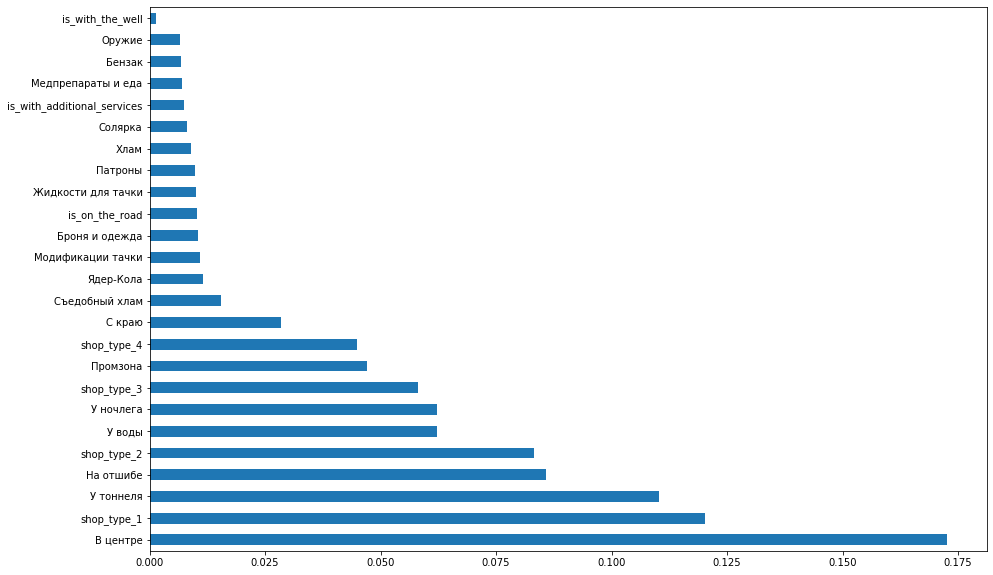

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# UNIVARIATE SELECTION

# data = pd.read_csv('C:\\Users\\Excel\\Desktop\\Briefcase\\PDFs\\1-ALL PYTHON & R CODE SAMPLES\\Feature Selection - Machine Learning\\train.csv')
x = df4 #independent columns
y = dbscan.labels_    #target column i.e price range

   
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
fig = plt.figure(figsize=(15,10))
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(25).plot(kind='barh')
features = feat_importances.nlargest(25)

plt.show()

In [1666]:
f = list(features.keys())

In [1667]:
new = df5[f]

In [1668]:
new

,В центре,У тоннеля,shop_type_1,На отшибе,У воды,shop_type_2,shop_type_3,Промзона,У ночлега,shop_type_4,...,Ядер-Кола,Модификации тачки,Съедобный хлам,Дизельные Жилы,Хлам,Крепость Джита,Пасть,Солярка,Патроны,Оружие
0,1,0,1,0,0,0,0,0,0,0,...,0.000000e+00,0.000000,0.000092,0,0.000116,0,0,0.000000,0.000000,0.000000
1,1,0,1,0,0,0,0,0,0,0,...,0.000000e+00,0.000000,0.002208,0,0.000578,0,0,0.168144,0.000000,0.000000
2,0,0,0,0,0,1,0,1,0,0,...,5.821388e-03,0.000683,0.014252,0,0.004939,0,0,0.170219,0.078597,0.000312
3,0,0,0,0,0,0,1,0,1,0,...,2.157645e-07,0.000003,0.001383,0,0.000765,0,0,0.103541,0.000000,0.000001
4,1,0,1,0,0,0,0,0,0,0,...,6.855079e-03,0.000716,0.012258,0,0.003383,0,0,0.137891,0.033738,0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,1,0,1,0,0,0,0,0,0,0,...,9.116804e-03,0.001505,0.013707,0,0.006279,0,1,0.198716,0.022609,0.000622
841,1,0,1,0,0,0,0,0,0,0,...,7.572002e-03,0.000891,0.013597,0,0.004801,0,0,0.175535,0.027760,0.000686
842,1,0,1,0,0,0,0,0,0,0,...,1.703058e-02,0.001520,0.021839,0,0.005090,0,0,0.212102,0.029397,0.001175
843,1,0,1,0,0,0,0,0,0,0,...,7.861145e-03,0.000727,0.013668,0,0.004365,0,0,0.141825,0.034893,0.000813


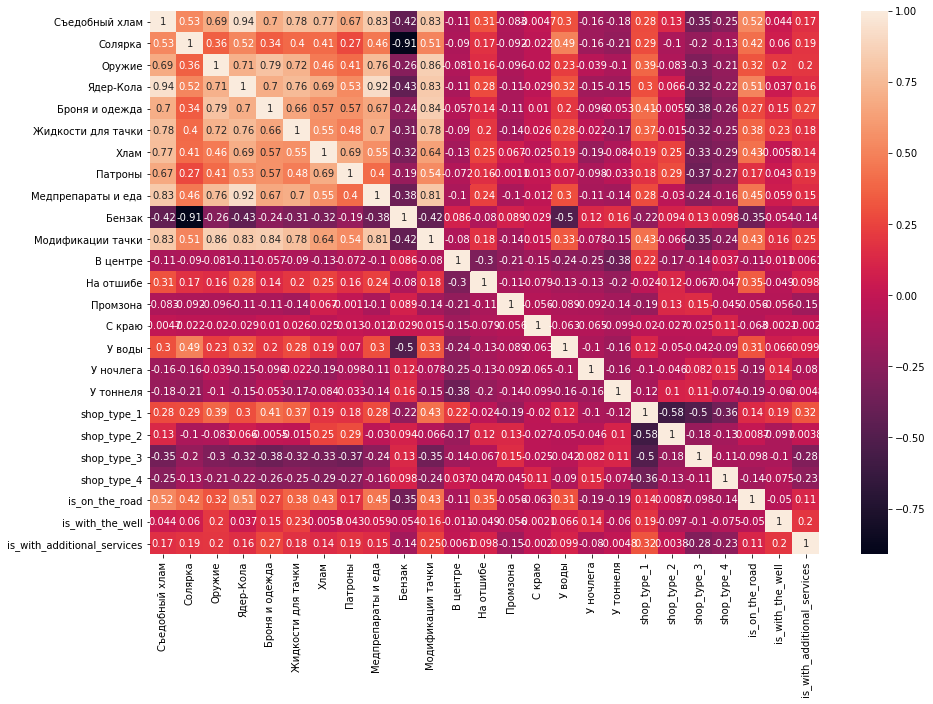

In [57]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df4.corr(), annot = True)

Предсказание и запись в df

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from typing import Tuple

### Запись результата в csv файл

In [1687]:
def get_clusters(X_train: pd.DataFrame, X_test: pd.DataFrame, n_clusters: int):
    """
    applies k-means clustering to training data to find clusters and predicts them for the test set
    """
    clustering = KMeans(n_clusters=n_clusters, random_state=8675309,n_jobs=-1)
    clustering.fit(X_train)
    # apply the labels
    train_labels = clustering.labels_
    X_train_clstrs = X_train.copy()
    X_train_clstrs['clusters'] = train_labels
    
    # predict labels on the test set
    test_labels = clustering.predict(X_test)
    X_test_clstrs = X_test.copy()
    X_test_clstrs['clusters'] = test_labels
    return X_train_clstrs, X_test_clstrs


In [1688]:
X_train_clstrs, X_test_clstrs = get_clusters(df3, df3, 10)

In [1689]:
metrics.silhouette_score(d, X_test_clstrs['clusters'])

-0.2179605461215871

In [1561]:
X_test_clstrs = X_test_clstrs.sort_values('clusters')

In [1562]:
X_test_clstrs

,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,...,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services,clusters
556,0.000951,0.001214,0.004941,0.048989,0.275203,0.003823,0.957559,0.057205,0.010663,0.038952,...,0,0,0,1,0,0,1.0,0.0,0.0,0
328,0.000002,0.000004,0.000000,0.000000,0.192601,0.000106,0.981277,0.000222,0.000111,0.000000,...,0,0,0,0,1,0,1.0,0.0,1.0,0
336,0.000000,0.000000,0.000000,0.000000,0.269917,0.000000,0.962884,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0.0,0.0,1.0,0
449,0.001751,0.000426,0.003287,0.017573,0.205866,0.000839,0.978341,0.008889,0.003410,0.007383,...,0,0,0,1,0,0,0.0,0.0,1.0,0
576,0.001191,0.000797,0.005650,0.039912,0.281580,0.003069,0.957912,0.030584,0.009776,0.021170,...,0,0,0,1,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,0.000000,0.000000,0.000000,0.000000,0.133968,0.000000,0.990986,0.000000,0.000000,0.000000,...,1,0,0,0,0,1,0.0,0.0,0.0,9
435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0.0,0.0,0.0,9
786,0.000084,0.000028,0.000000,0.001990,0.079881,0.000196,0.996799,0.001879,0.001591,0.000300,...,0,0,0,0,0,1,0.0,0.0,0.0,9
23,0.000000,0.000000,0.000000,0.000000,0.123671,0.000000,0.992323,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0.0,0.0,0.0,9


In [1563]:
X = X_test_clstrs.groupby(['clusters'], as_index=False).mean()*100 # выкидываются важные бинарные признаки
X

,clusters,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services
0,0,0.201192,0.132046,0.946235,3.827461,24.509617,0.162308,96.110540,2.733149,0.785790,...,6.000000,0.000000,0.000000,0.0,80.0,14.0,6.0,84.000000,0.000000,48.000000
1,100,0.196529,0.114864,0.617770,2.472560,20.484944,0.120322,97.031488,1.576851,0.442018,...,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.0,24.561404,2.631579,0.000000
2,200,0.210231,0.110263,0.450956,2.768012,17.109657,0.101080,98.015552,1.159752,0.459255,...,0.000000,0.000000,100.000000,100.0,0.0,0.0,0.0,11.904762,7.142857,65.476190
3,300,0.172421,0.073056,0.292210,3.875877,16.439112,0.085064,97.792320,1.510096,0.546784,...,5.454545,9.090909,39.090909,0.0,100.0,0.0,0.0,8.181818,1.818182,41.818182
4,400,0.027028,0.009725,0.019661,0.712447,14.008989,0.026082,98.173228,0.288830,0.191305,...,6.481481,16.666667,33.333333,0.0,0.0,100.0,0.0,10.185185,0.000000,7.407407
5,500,0.240420,0.132866,0.551655,3.066205,24.006342,0.127257,95.351861,1.641562,0.496440,...,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.0,26.271186,12.711864,100.000000
6,600,0.298552,0.196904,1.346966,3.407441,32.816810,0.184501,93.049387,2.790938,0.653966,...,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.0,58.208955,5.970149,68.656716
7,700,0.353550,0.274403,1.738038,3.443825,50.804776,0.239414,82.573959,3.322510,0.720206,...,100.000000,0.000000,0.000000,100.0,0.0,0.0,0.0,75.409836,13.114754,63.934426
8,800,0.270358,0.157621,0.625132,3.423865,20.272338,0.179563,97.351734,1.678831,0.488186,...,0.000000,50.684932,0.000000,100.0,0.0,0.0,0.0,10.958904,23.287671,49.315068
9,900,0.036823,0.016399,0.039577,0.735972,14.577448,0.019716,98.282077,0.271090,0.130916,...,0.000000,26.666667,10.000000,0.0,0.0,0.0,100.0,0.000000,0.000000,3.333333


In [1564]:
X = X_test_clstrs.groupby(['clusters'], as_index=False).sum()

In [1565]:
X


,clusters,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services
0,0,0.100596,0.066023,0.473118,1.913730,12.254808,0.081154,48.055270,1.366574,0.392895,...,3,0,0,0,40,7,3,42.0,0.0,24.0
1,1,0.224043,0.130945,0.704257,2.818718,23.352837,0.137167,110.615896,1.797610,0.503900,...,0,0,0,114,0,0,0,28.0,3.0,0.0
2,2,0.176594,0.092621,0.378803,2.325130,14.372112,0.084907,82.333063,0.974191,0.385774,...,0,0,84,84,0,0,0,10.0,6.0,55.0
3,3,0.189663,0.080362,0.321431,4.263465,18.083024,0.093571,107.571552,1.661106,0.601462,...,6,10,43,0,110,0,0,9.0,2.0,46.0
4,4,0.029191,0.010503,0.021234,0.769443,15.129709,0.028168,106.027086,0.311936,0.206609,...,7,18,36,0,0,108,0,11.0,0.0,8.0
5,5,0.283696,0.156782,0.650953,3.618121,28.327484,0.150164,112.515196,1.937043,0.585799,...,0,0,0,118,0,0,0,31.0,15.0,118.0
6,6,0.200030,0.131926,0.902467,2.282985,21.987263,0.123615,62.343089,1.869929,0.438157,...,0,0,0,67,0,0,0,39.0,4.0,46.0
7,7,0.215665,0.167386,1.060203,2.100733,30.990913,0.146043,50.370115,2.026731,0.439325,...,61,0,0,61,0,0,0,46.0,8.0,39.0
8,8,0.197361,0.115063,0.456346,2.499421,14.798807,0.131081,71.066766,1.225547,0.356376,...,0,37,0,73,0,0,0,8.0,17.0,36.0
9,9,0.022094,0.009839,0.023746,0.441583,8.746469,0.011830,58.969246,0.162654,0.078549,...,0,16,6,0,0,0,60,0.0,0.0,2.0


In [1500]:
X.to_csv('out1.csv', index=False)  

In [ ]:
pd.DataFrame

 Новый способ масштабирования

In [1572]:
year = shops["year_opened"]

In [1567]:
year.head(5)

259    2136
770    2115
592    2115
701    2092
628    2108
Name: year_opened, dtype: int64

In [1574]:
X_test_scaled = scale_features(df)

In [1575]:
X_test_scaled

array([[-1.11 , -0.974, -0.614, ..., -0.601, -0.264, -0.891],
       [-1.037, -0.974, -0.614, ..., -0.601, -0.264, -0.891],
       [ 0.416, -0.39 , -0.574, ..., -0.601, -0.264,  1.122],
       ...,
       [ 0.043,  0.327,  0.279, ..., -0.601, -0.264, -0.891],
       [ 0.082, -0.352, -0.168, ..., -0.601, -0.264, -0.891],
       [-0.312, -0.203, -0.289, ..., -0.601, -0.264, -0.891]])

### 4.2. K-Means

In [58]:
# Импортируем библиотеки
from sklearn import datasets
from sklearn.cluster import KMeans


# Описываем модель
model = KMeans(n_clusters=25) # подумать о количестве кластеров

# Проводим моделирование
model.fit(df3)

# Предсказание на всем наборе данных
all_predictions = model.predict(df3)

# Выводим предсказания

print(all_predictions)
print(metrics.silhouette_score(d, all_predictions))

[ 0  0  1 17  0  5  0  0  0 18 16  0  0  7 19 19 20 11 11  4  2 20 19 12
  0 11  0  6  0  5  0  5  0 11  0  7  5  0  4  3  0 13 19  0 16  0 13 14
 20  6 20  0  6  7 12 10  0 24 13  0  0 11  0  0  0  0  1  1 13  0 13  0
  1 21  7  1  0  1  4 11 20  0  0  1 13 12  6  4  9  0  6  0  3  7 11  6
  3  1  7  3  7  0  7  0  6  6  0  6  0  7 14  0  3  0  0  1  0 11  6  0
  0  0  0 11  0  0  0  5  0  0  0  9  0  0  9 11  0  0 11  0 12  0  0  0
  0  0 10 10 24  0  0  4 14  9  6  0  0  0 10  0 24  0 11 11  0  9 20  9
  4  9  9  9  3  9  6  9  9 14 11 10 17 10 18  9  9  0 16  6  9  5  0  9
  0  2  9  9  7  4  0  9 11  1  2  4  2  2  2  0 20 17  0  2 13  2  0  0
 17  0  8  2 10  0  4  4  8  8  5  6  8  4  3  3  4  0  0  0 13 12 17  4
  3 13 13  2  2  3  2 12 17  2  4 17  4 16 10  0  2  2  4  4  8 13  4  2
  4  2  4  4  6  3  6  0 17  0  0  2  0 24  0  0  0 20 17  8 17  0 17  6
  4 10 10  0 10 10 13  6 14  0  4  6  6  6  4  8  8  4  0  4  0  4  4 14
  0 14  6 23  3  4  3 10  6 14  5  6  8  3  4  3 16

## 4.3. Иерархическая кластеризация

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

### Минимальное межкластерное расстояние

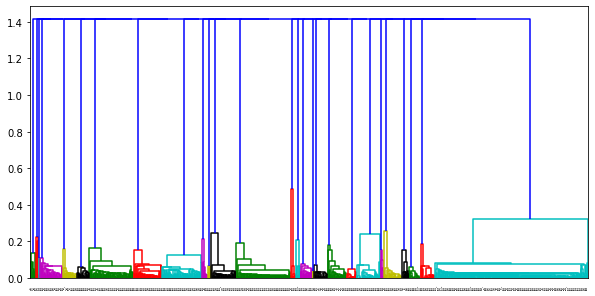

In [79]:
mergings3 = linkage(df3.to_numpy(), method='single')
mergings4 = linkage(df4.to_numpy(), method='single')

fig = plt.figure(figsize=(10, 5))
dendrogram(mergings3,leaf_font_size=2)

plt.show()


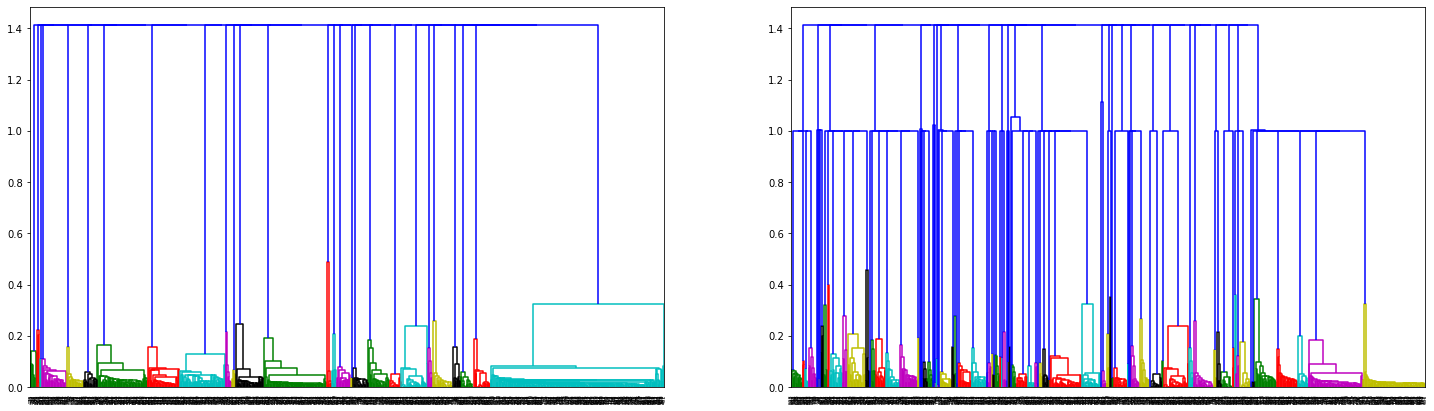

In [86]:
mergings3 = linkage(df3.to_numpy(), method='single')
mergings4 = linkage(df4.to_numpy(), method='single')

fig, axes = plt.subplots(1, 2, figsize=(25, 7))
dn1 = hierarchy.dendrogram(mergings3, ax=axes[0],
                          orientation='top')
dn2 = hierarchy.dendrogram(mergings4, ax=axes[1],
                        orientation='top')
plt.show()

In [ ]:
len(set(dendrogram(mergings)['color_list']))

### Максимальное межкластерное расстояние

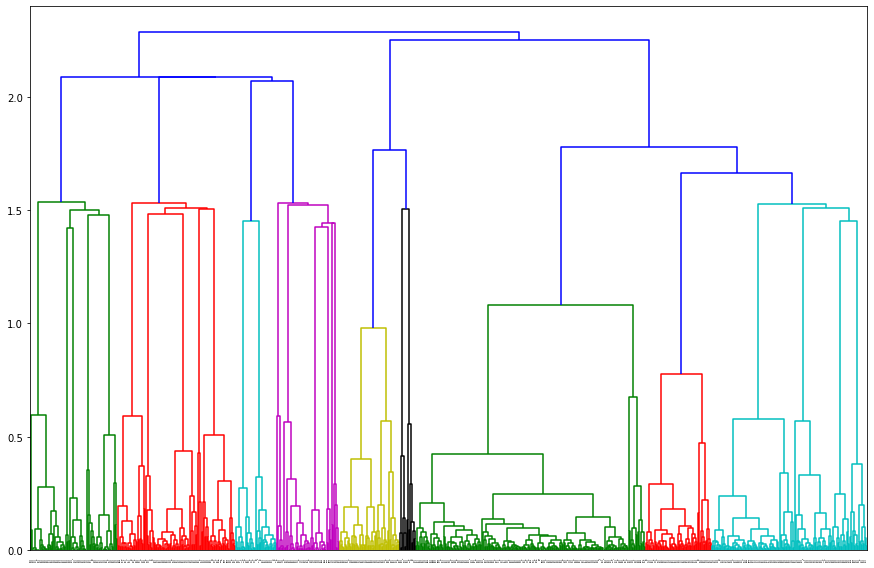

In [75]:
mergings = linkage(df3.to_numpy(), method='complete')

fig = plt.figure(figsize=(15,10))
dendrogram(mergings, leaf_font_size=2)

plt.show()

### Метод невзвешенного попарного среднего

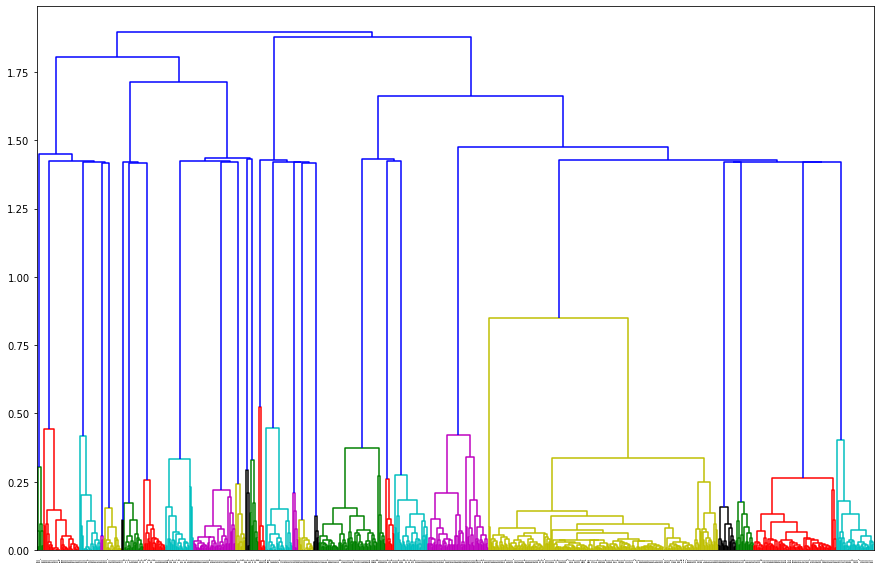

In [76]:
mergings = linkage(df3.to_numpy(), method='average')

fig = plt.figure(figsize=(15,10))
dendrogram(mergings,
           leaf_font_size=2)

plt.show()

### Метод взвешенного попарного среднего

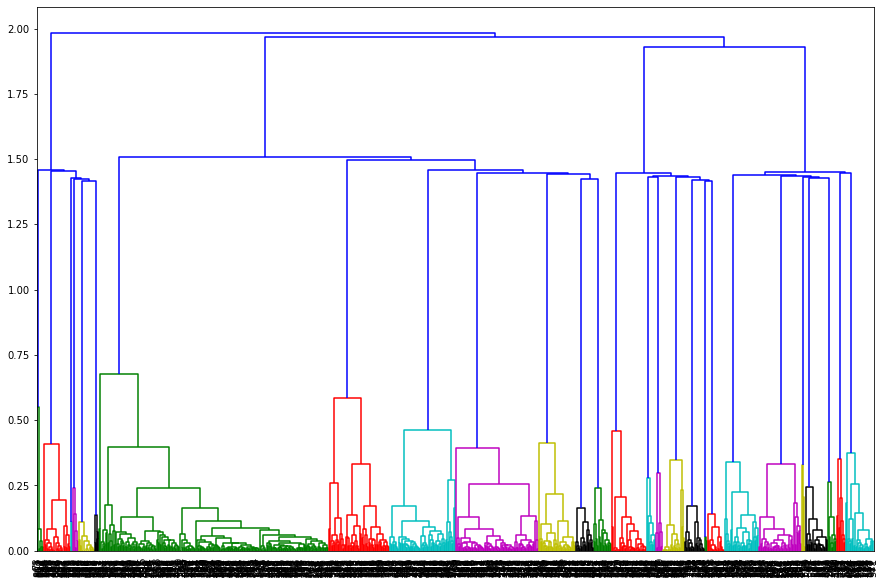

In [1779]:
mergings = linkage(df3.to_numpy(), method='weighted'
                  )
fig = plt.figure(figsize=(15,10))
dendrogram(mergings,
#            labels=varieties,
           leaf_rotation=90,
           leaf_font_size=10,
           )
# plt.figure(figsize=(20,10))
# plt.figure(figsize=(1,1))
plt.show()

In [ ]:
настоить размер:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html 

In [ ]:
повекра качества результатов 

In [88]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

In [90]:
alg = AgglomerativeClustering(n_clusters=25)
alg.fit(df3)
alg.labels_

array([ 2,  2, 20, 19,  2, 15,  2,  2,  2, 22, 16,  2,  2, 10, 13, 13, 18,
        6,  6,  4, 11, 18, 13,  7,  2,  6,  2,  3,  2, 15,  2, 15,  2,  6,
        2, 10, 15,  2,  4,  1,  2, 17, 13,  2, 16,  2, 17, 12, 18,  3, 18,
        2,  3, 10,  7, 14,  2,  0, 17,  2,  2,  6,  2,  2,  2,  2, 20, 20,
       17,  2, 17,  2, 20, 23, 10, 20,  2, 20,  4,  6, 18,  2,  2, 20, 17,
        7,  3,  4,  8,  2,  3,  2,  1, 10,  6,  3,  1, 20, 10,  1, 10,  2,
       10,  2,  3,  3,  2,  3,  2, 10, 12,  2,  1,  2,  2, 20,  2,  6,  3,
        2,  2,  2,  2,  6,  2,  2,  2, 15,  2,  2,  2,  8,  2,  2,  8,  6,
        2,  2,  6,  2,  7,  2,  2,  2,  2,  2, 14, 14,  0,  2,  2,  4, 12,
        8,  3,  2,  2,  2, 14,  2,  0,  2,  6,  6,  2,  8, 18,  8,  4,  8,
        8,  8,  1,  8,  3,  8,  8, 12,  6, 14, 19, 14, 22,  8,  8,  2, 16,
        3,  8, 15,  2,  8,  2, 11,  8,  8, 10,  4,  2,  8,  6, 20, 11,  4,
       11, 11, 11,  2, 18, 19,  2, 11, 17, 11,  2,  2, 19,  2,  9, 11, 14,
        2,  4,  4,  9,  9

In [601]:
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=5)
    clustering.fit(data)
    
    print(metrics.silhouette_score(data, clustering.labels_))

0.12082585223821937
0.17942524589922335
0.12336133554669082
0.017129940042098838


In [ ]:
0.5494873408232994
0.5539784808859305
0.5532355555181032
0.4302314021185118

In [ ]:
варианты алгоритмов

In [ ]:
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

In [390]:
print(metrics.silhouette_score(data2, algo_labels))
print(metrics.silhouette_score(data2, all_predictions))

0.1850243270794171
0.5344327316650442


In [92]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility

def show_cluster(data2):
    data2 = data2.to_numpy()

    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 21, 22, 25, 26, 27, 28,29,30]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data2) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data2)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data2, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data2[:, 0], data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

Automatically created module for IPython interactive environment


For n_clusters = 2 The average silhouette_score is : 0.31382323010713015
For n_clusters = 3 The average silhouette_score is : 0.34248380824530583
For n_clusters = 4 The average silhouette_score is : 0.3977983120379707
For n_clusters = 5 The average silhouette_score is : 0.4393264048223695
For n_clusters = 6 The average silhouette_score is : 0.49504945758572144
For n_clusters = 7 The average silhouette_score is : 0.5517188202904054
For n_clusters = 8 The average silhouette_score is : 0.5643500682055035
For n_clusters = 9 The average silhouette_score is : 0.6122357432921968
For n_clusters = 10 The average silhouette_score is : 0.6355271574680288
For n_clusters = 11 The average silhouette_score is : 0.6663706805809416
For n_clusters = 12 The average silhouette_score is : 0.6973650637154467
For n_clusters = 20 The average silhouette_score is : 0.8501968359300583
For n_clusters = 21 The average silhouette_score is : 0.863351563546469
For n_clusters = 22 The average silhouette_score is : 0.8

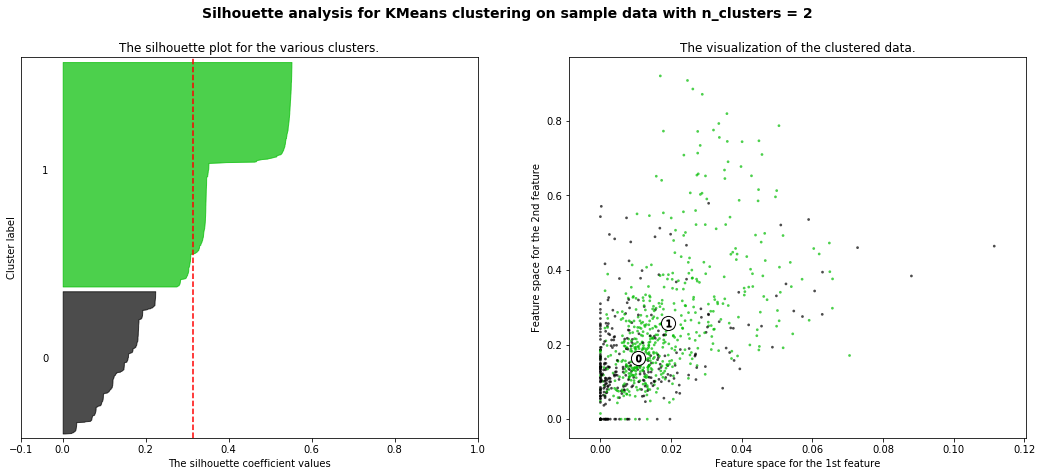

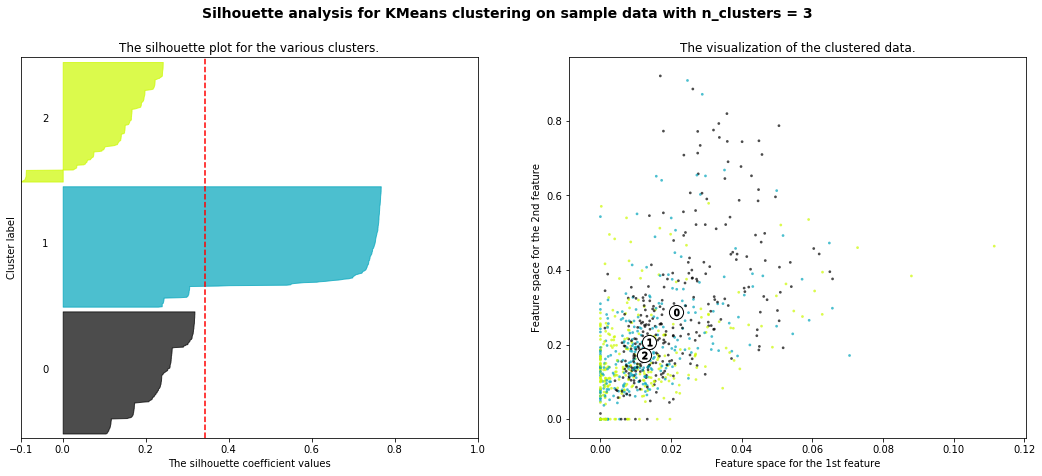

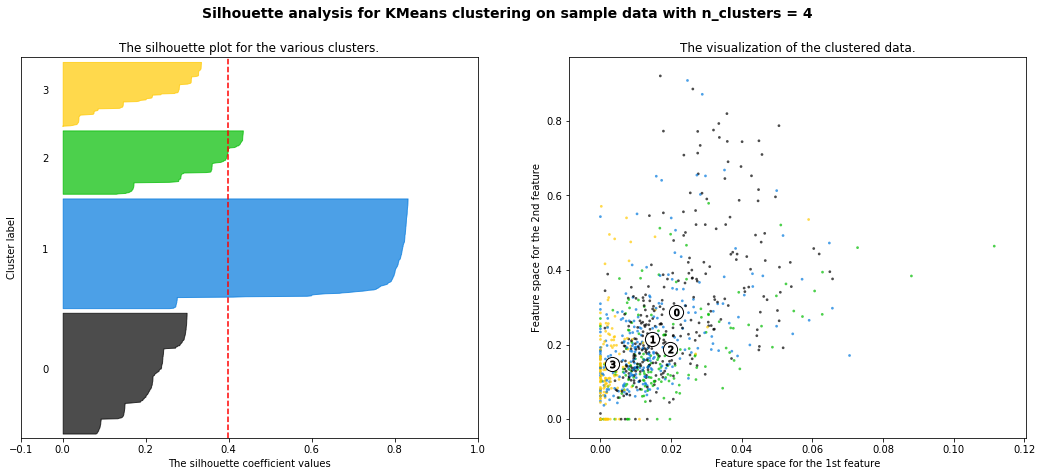

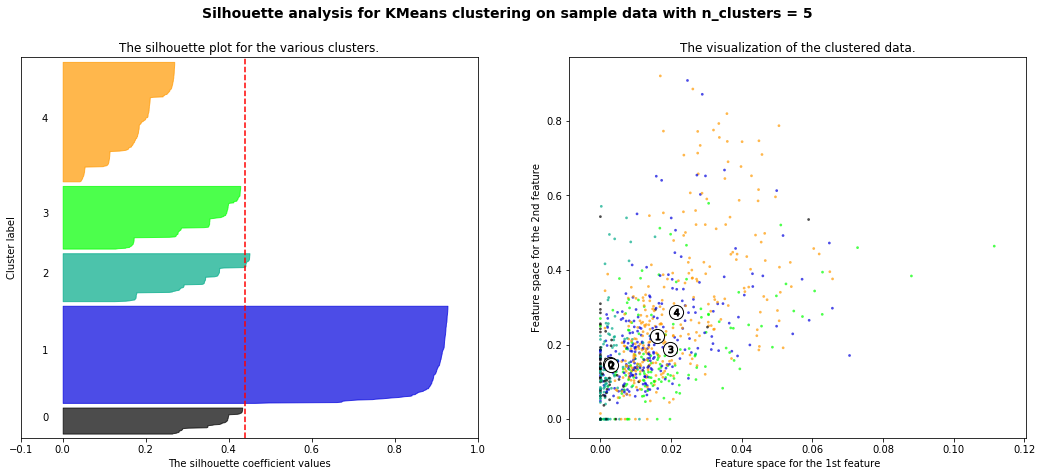

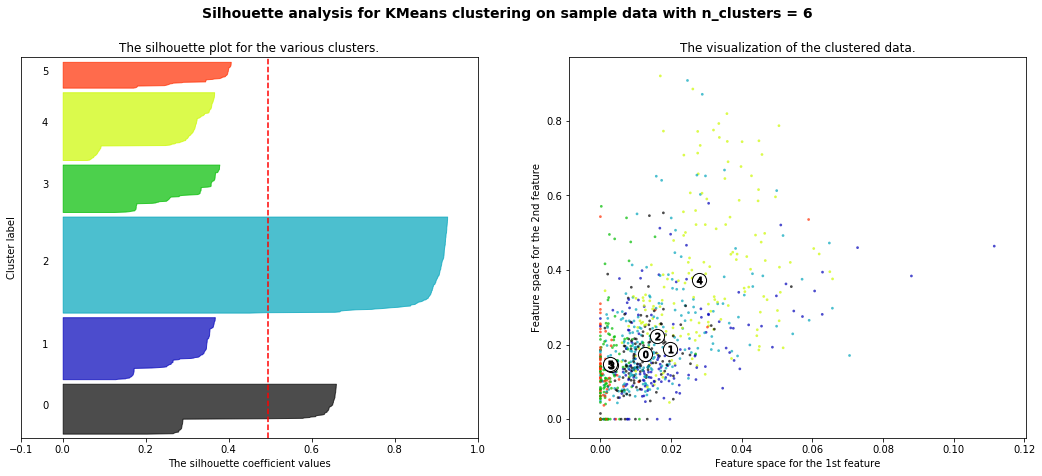

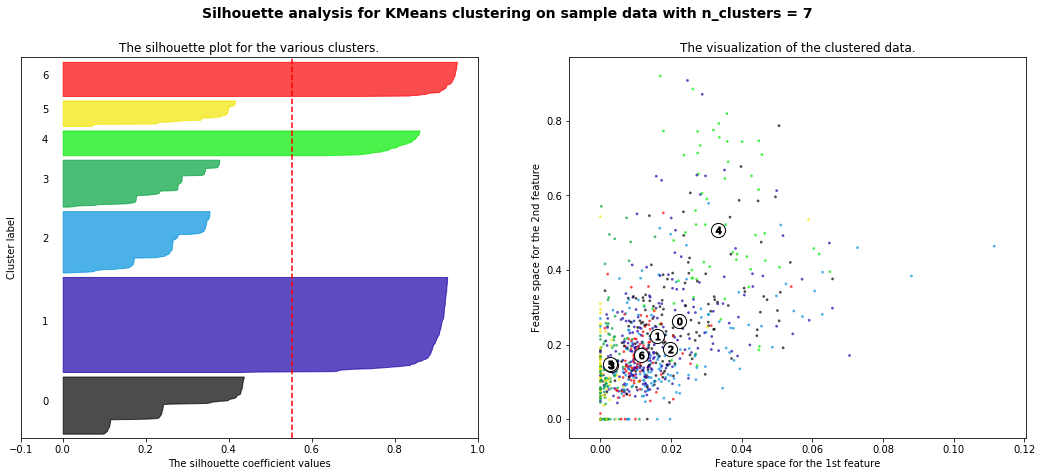

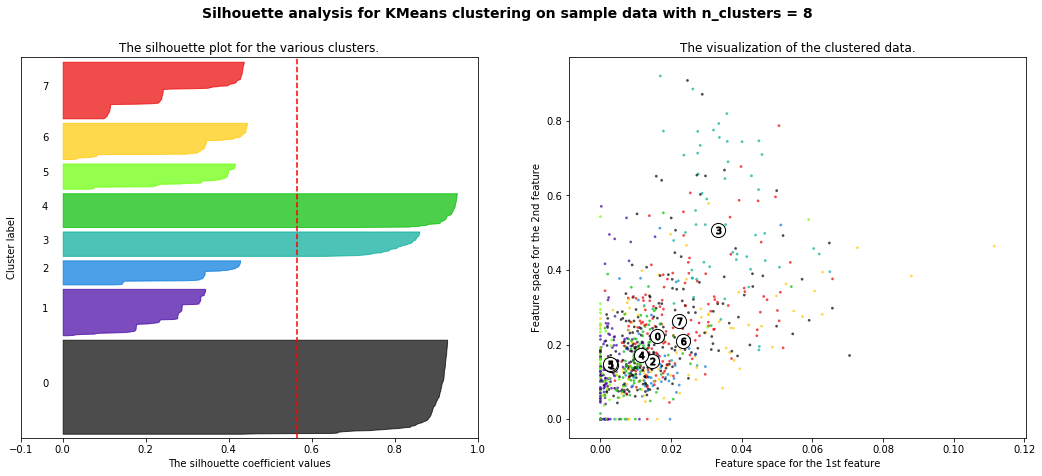

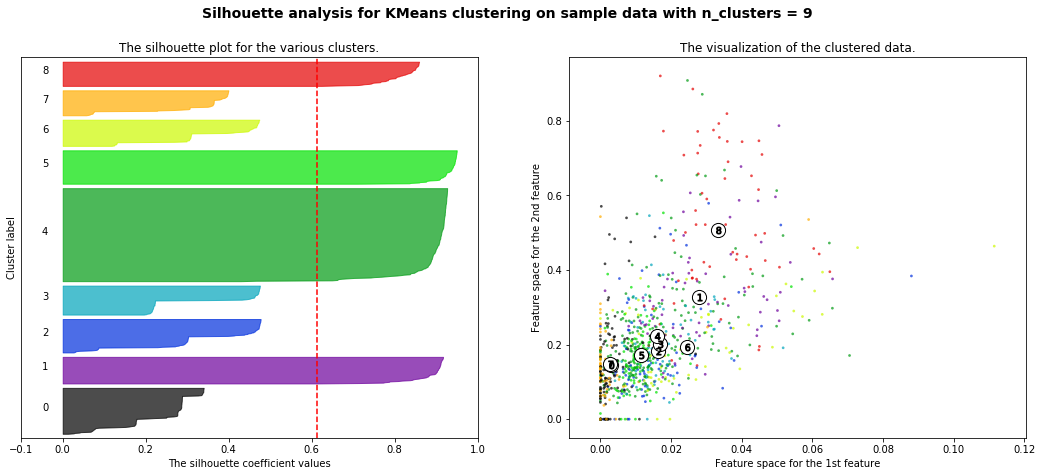

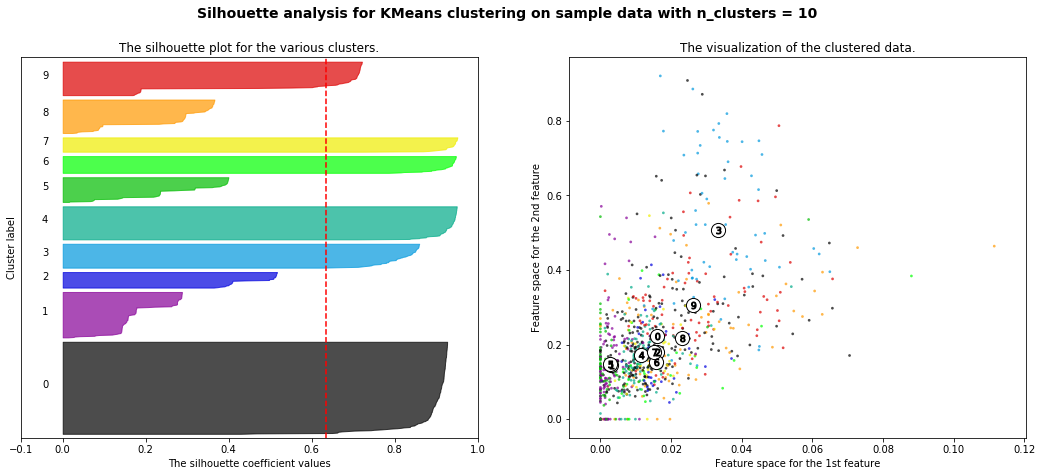

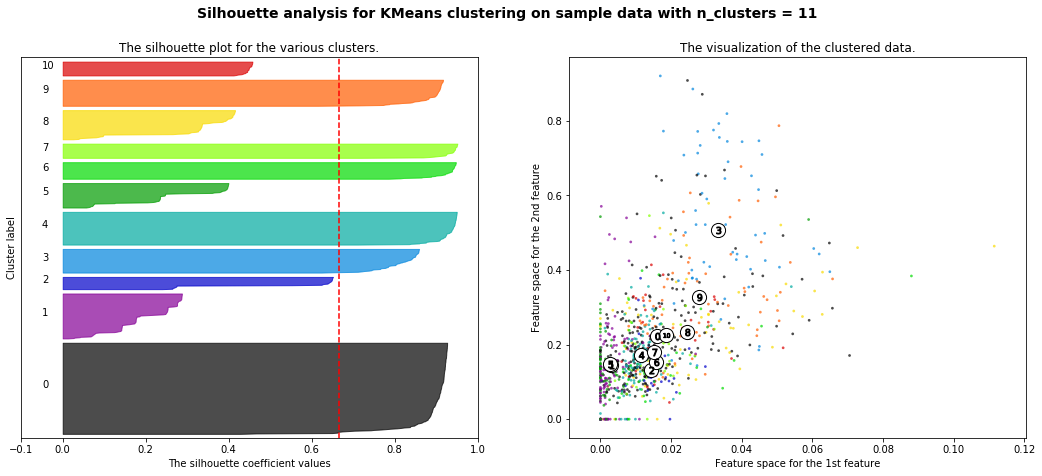

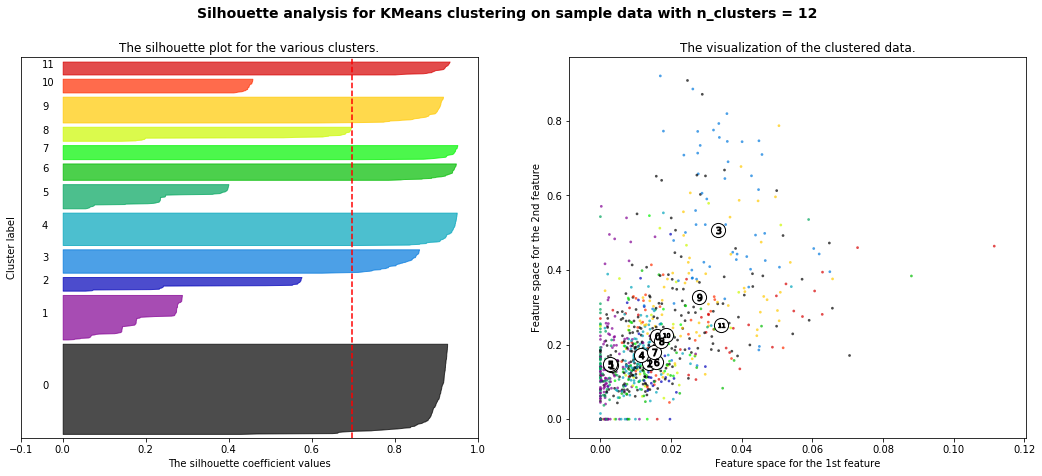

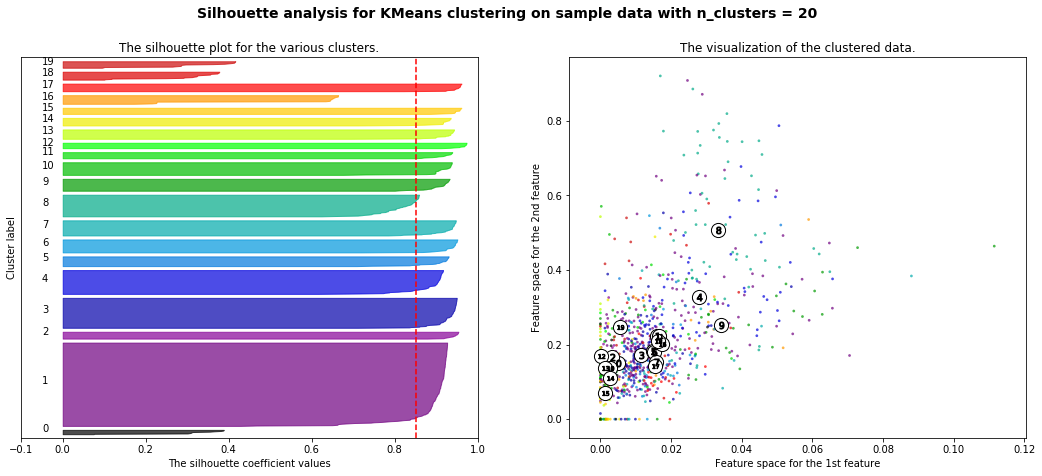

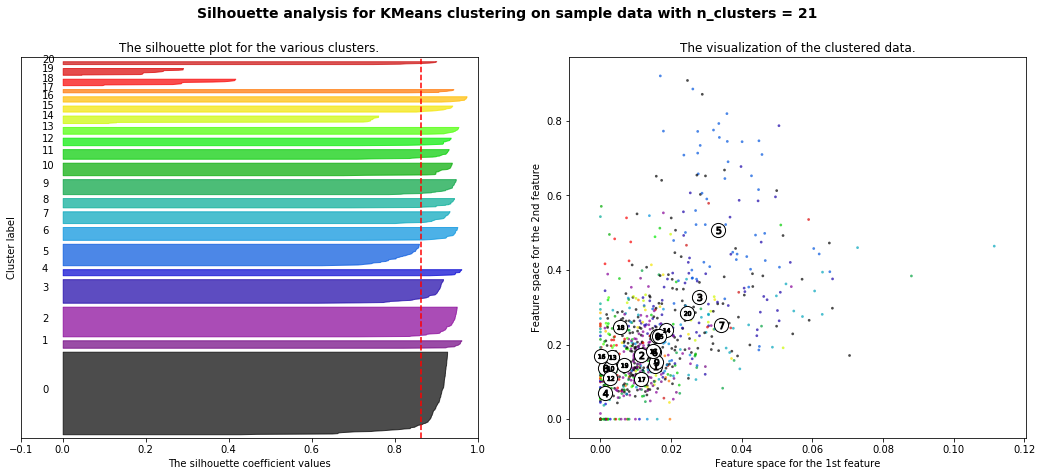

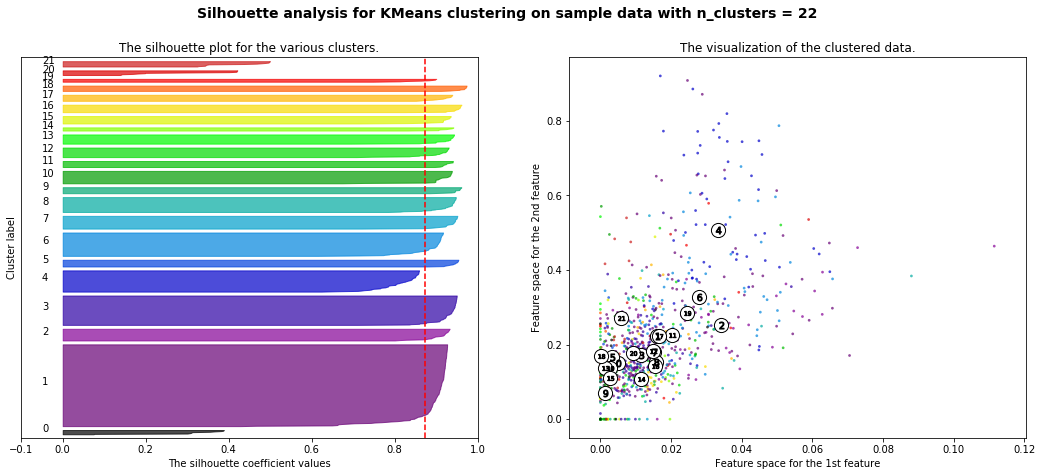

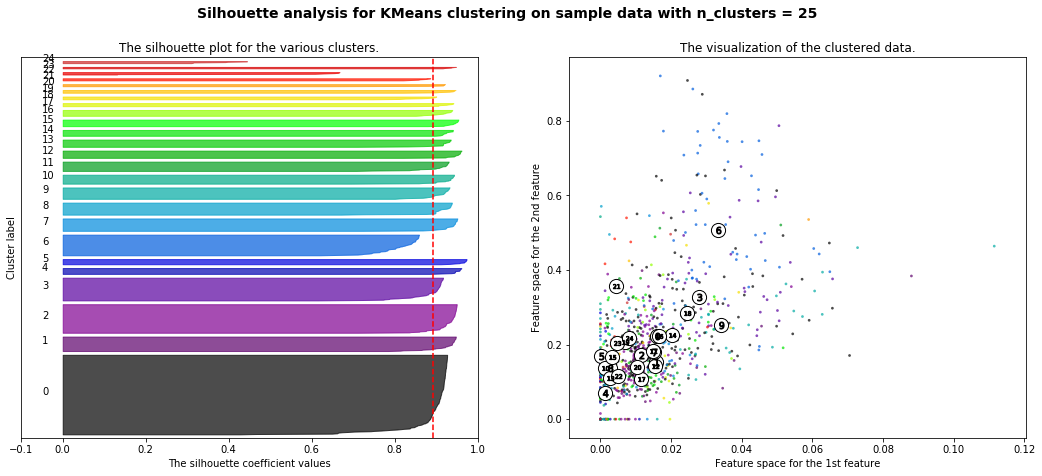

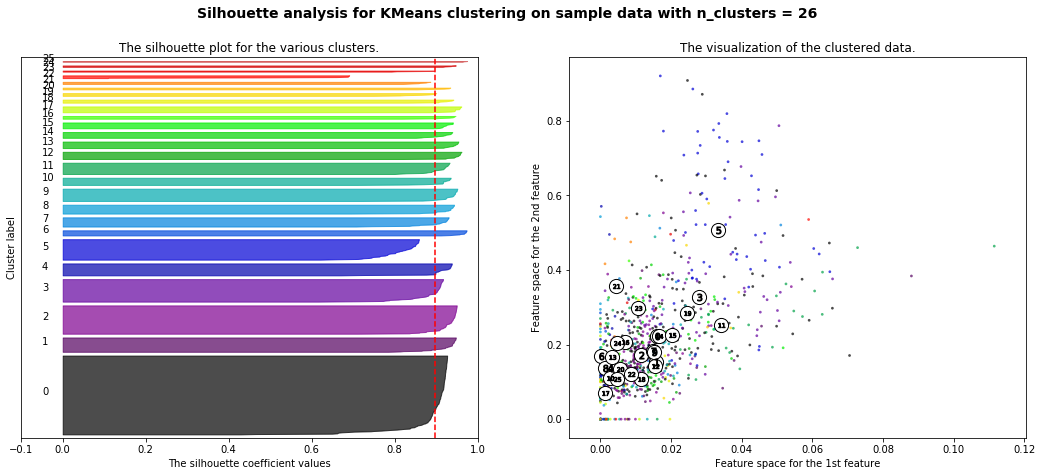

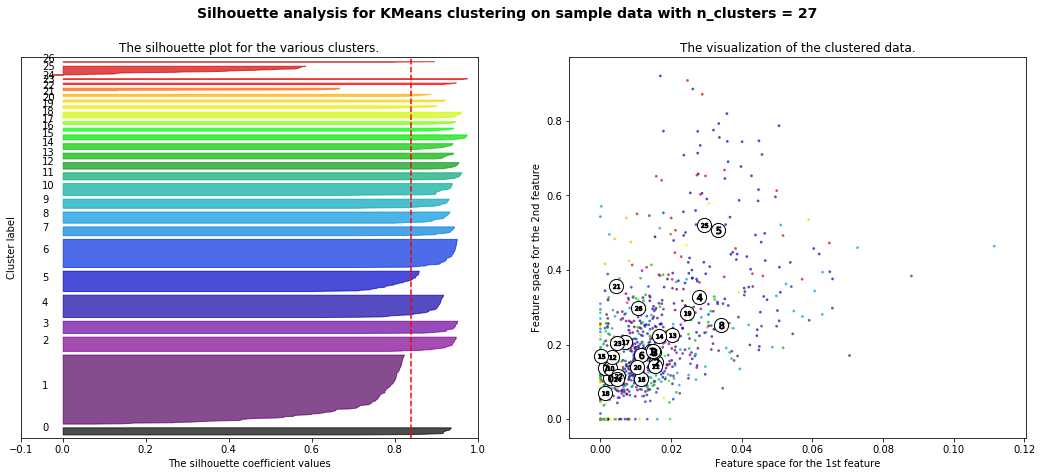

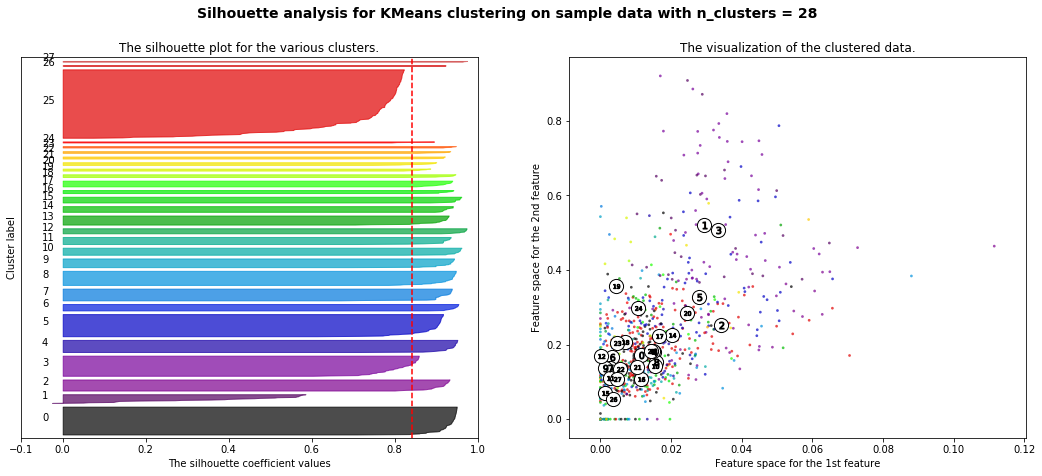

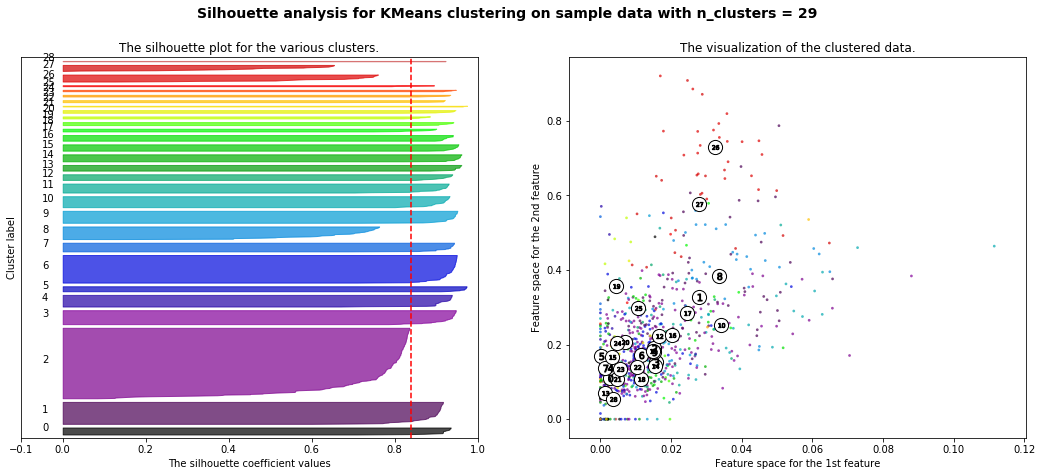

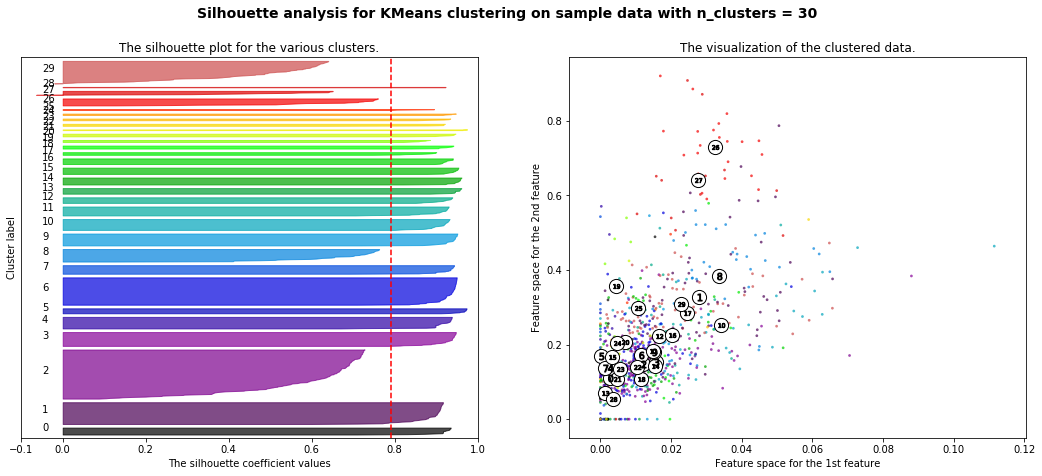

In [95]:
show_cluster(df3)

## & 5. Интерпритация результата

In [ ]:
X_test_clstrs = X_test_clstrs.sort_values('clusters')

In [ ]:
X_test_clstrs.groupby(['clusters'], as_index=False).mean()

In [1795]:
df = df3

In [96]:
df3

,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,1,0,0,0
1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.985760,...,0,0,0,0,0,0,1,0,0,0
2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.982130,...,0,1,0,0,0,0,0,1,0,0
3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.994624,...,0,0,0,0,1,0,0,0,1,0
4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.989765,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0.013707,0.198716,0.000622,9.116804e-03,0.002700,0.000866,0.006279,0.022609,0.005366,0.979618,...,0,0,0,0,0,0,1,0,0,0
841,0.013597,0.175535,0.000686,7.572002e-03,0.001612,0.000982,0.004801,0.027760,0.003974,0.983936,...,0,0,0,0,0,0,1,0,0,0
842,0.021839,0.212102,0.001175,1.703058e-02,0.002015,0.001725,0.005090,0.029397,0.008594,0.976356,...,0,0,0,0,0,0,1,0,0,0
843,0.013668,0.141825,0.000813,7.861145e-03,0.002083,0.000676,0.004365,0.034893,0.004297,0.989129,...,0,0,0,0,0,0,1,0,0,0
